In [ ]:
import os
import pandas as pd
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback


class TqdmCallback(BaseCallback):
    def __init__(self, total_timesteps: int, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps

    def _on_training_start(self) -> None:
        self.pbar = tqdm(total=self.total_timesteps, desc="Training")

    def _on_step(self) -> bool:
        self.pbar.update(1)
        return True

    def _on_training_end(self) -> None:
        self.pbar.close()


data_dir = os.path.expanduser("/Users/diananigmatullina/Downloads/data_thesis")
df_list = []
for root, _, files in os.walk(data_dir):
    for fname in files:
        if fname.lower().endswith(".csv.gz"):
            path = os.path.join(root, fname)
            tmp = pd.read_csv(path, parse_dates=["timestamp"])
            df_list.append(tmp[["timestamp", "asks[0].price", "bids[0].price"]])
if not df_list:
    raise ValueError(f"No CSV files found in {data_dir}")
df = pd.concat(df_list, ignore_index=True)
df.sort_values("timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)

mid = (df["asks[0].price"] + df["bids[0].price"]) / 2
real_sigma = mid.pct_change().dropna().std()

split = int(len(df) * 0.8)
df_train, df_test = df.iloc[:split], df.iloc[split:]


class MarketMakingEnv(gym.Env):
    metadata = {"render.modes": []}

    def __init__(
        self,
        df: pd.DataFrame,
        dt: float = 0.05,
        kappa: float = 0.1,
        A: float = 15.0,
        k: float = 10.0,
        beta: float = 1.0,
        sigma: float = real_sigma,
        na: int = 21,
        da: float = 0.005,
        fee: float = 0.001,
    ):
        super().__init__()
        self.dt, self.kappa, self.A, self.k = dt, kappa, A, k
        self.beta, self.sigma = beta, sigma
        self.na, self.da, self.fee = na, da, fee
       
        self.Phi = 2.0 / self.beta * np.log(1 + self.beta / self.k)
        self.half_spread = self.Phi / 2.0
       
        self.mid_prices = ((df["asks[0].price"] + df["bids[0].price"]) / 2.0).values
        self.max_steps = len(self.mid_prices) - 1

        self.action_space = spaces.Discrete(self.na)
        high = np.array([np.finfo(np.float32).max, np.finfo(np.float32).max, self.max_steps], dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.reset()

    def _get_obs(self):
        s = self.mid_prices[self.step_idx]
        tau = self.max_steps - self.step_idx
        return np.array([s, self.inventory, tau], dtype=np.float32)

    def reset(self):
        self.step_idx = 0
        self.inventory = 0.0
        self.cash = 0.0
        self.prev_wealth = 0.0
        self.mu_hat = 0.0
        self.steps = 0
        self.realized_pnl_series = []
        self.delta_w_series = []
        return self._get_obs()

    def step(self, action: int):
        s = self.mid_prices[self.step_idx]
        mid_idx = (self.na - 1) / 2.0
        shift = (action - mid_idx) * self.da
        tau = self.max_steps - self.step_idx

        rho = s - self.beta * (self.sigma ** 2) * tau * self.inventory

        p_bid = rho + shift - self.half_spread
        p_ask = rho + shift + self.half_spread

        lam = self.A * np.exp(-self.k * self.half_spread)
        n_b = np.random.poisson(lam * self.dt)
        n_a = np.random.poisson(lam * self.dt)

        pnl_b = p_bid * n_b * (1 - self.fee)
        pnl_a = p_ask * n_a * (1 - self.fee)
        realized = pnl_a - pnl_b

        self.inventory += n_b - n_a
        self.cash += realized
        self.step_idx += 1
        done = self.step_idx >= self.max_steps

        s_next = self.mid_prices[self.step_idx]
        wealth = self.cash + self.inventory * s_next
        delta_w = wealth - self.prev_wealth
        self.prev_wealth = wealth

        self.mu_hat = (self.steps * self.mu_hat + delta_w) / (self.steps + 1)
        self.steps += 1

        reward = delta_w - 0.5 * self.kappa * (delta_w - self.mu_hat) ** 2

        self.realized_pnl_series.append(realized)
        self.delta_w_series.append(delta_w)

        return self._get_obs(), reward, done, {}


env_train = MarketMakingEnv(df_train)

total_timesteps = env_train.max_steps * 10 // 50

model = DQN(
    "MlpPolicy",
    env_train,
    learning_rate=5e-4,
    batch_size=256,
    gamma=0.995,
    train_freq=1,
    target_update_interval=5000,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    buffer_size=200_000,
    verbose=0,
)
model.learn(total_timesteps=total_timesteps, callback=TqdmCallback(total_timesteps))
model.save("dqn_mm_selser")


env_test = MarketMakingEnv(df_test)
obs = env_test.reset()
inv_series, cum_realized, cum_reward, steps = [], [], [], []
tr, tw = 0.0, 0.0
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_test.step(action)
    tr += env_test.realized_pnl_series[-1]
    tw += reward
    inv_series.append(env_test.inventory)
    cum_realized.append(tr)
    cum_reward.append(tw)
    steps.append(len(steps))



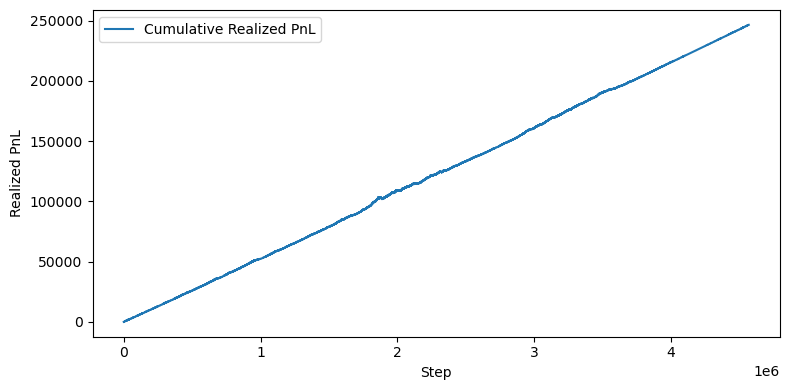

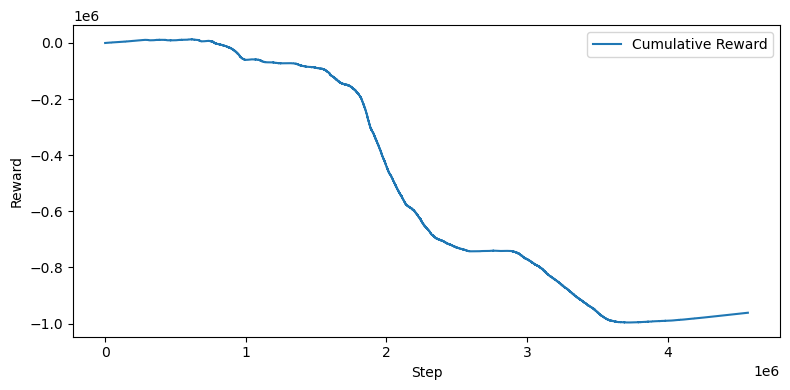

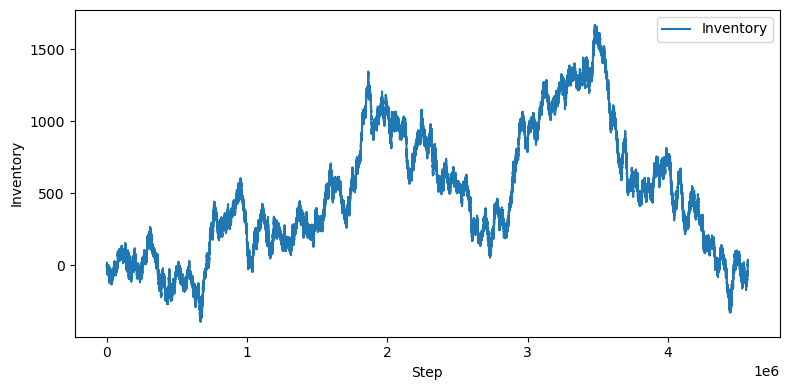

In [2]:
plt.figure(figsize=(8,4))
plt.plot(steps, cum_realized, label="Cumulative Realized PnL")
plt.xlabel("Step"); plt.ylabel("Realized PnL"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(steps, cum_reward, label="Cumulative Reward")
plt.xlabel("Step"); plt.ylabel("Reward"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(8,4))
plt.plot(steps, inv_series, label="Inventory")
plt.xlabel("Step"); plt.ylabel("Inventory"); plt.legend(); plt.tight_layout()

plt.show()

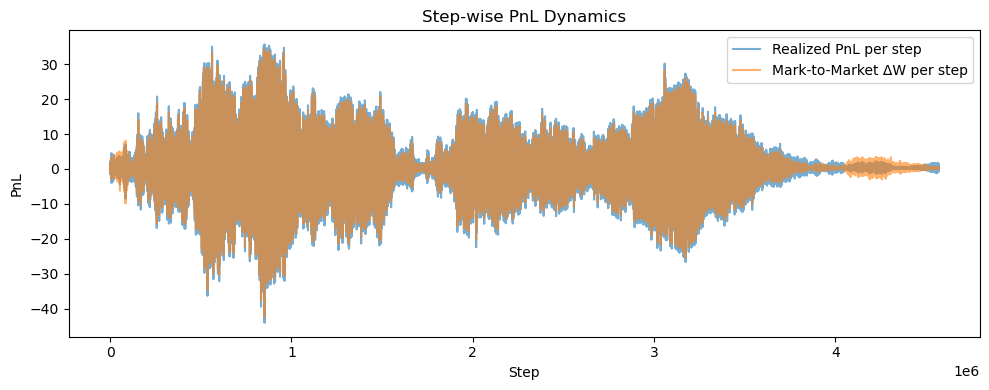

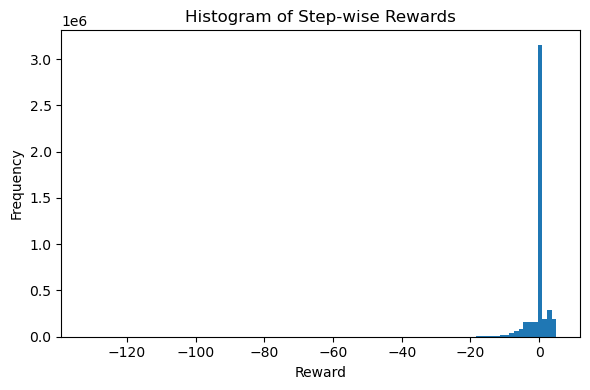

In [3]:
obs = env_test.reset()
inv_series = []
realized_series = []
delta_w_series = []
reward_series = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_test.step(action)

    realized_series.append(env_test.realized_pnl_series[-1])
    delta_w_series.append(env_test.delta_w_series[-1])
    reward_series.append(reward)
    inv_series.append(env_test.inventory)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(realized_series, alpha=0.6, label="Realized PnL per step")
plt.plot(delta_w_series, alpha=0.6, label="Mark-to-Market ΔW per step")
plt.xlabel("Step")
plt.ylabel("PnL")
plt.title("Step-wise PnL Dynamics")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.hist(reward_series, bins=100)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Histogram of Step-wise Rewards")
plt.tight_layout()
plt.show()

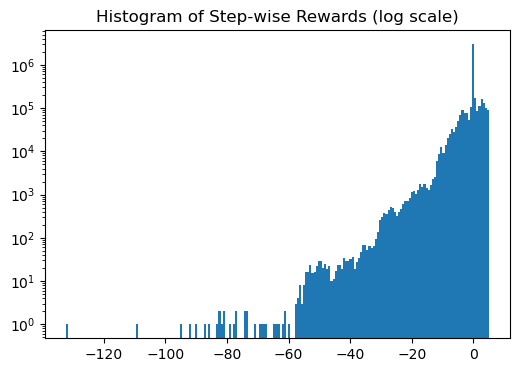

In [4]:
plt.figure(figsize=(6,4))
plt.hist(reward_series, bins=200, log=True)
plt.title("Histogram of Step-wise Rewards (log scale)")
plt.show()

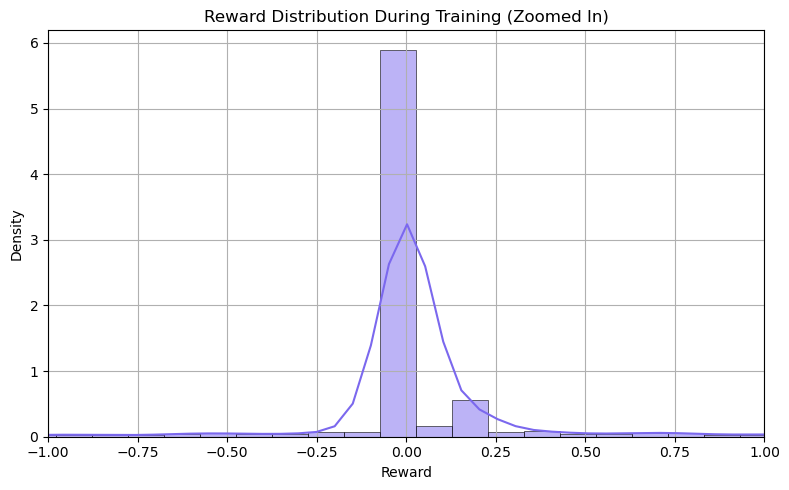

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rewards = np.array(reward_series)

rewards_clipped = rewards[(rewards > -5) & (rewards < 10)]

plt.figure(figsize=(8, 5))

sns.histplot(rewards_clipped, bins=100, kde=True, color='mediumslateblue', stat='density')

plt.title("Reward Distribution During Training (Zoomed In)")
plt.xlabel("Reward")
plt.ylabel("Density")
plt.xlim(-1, 1)  
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_41008/315119968.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp = pd.read_csv(os.path.join(root,f), parse_dates=["timestamp"])
/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_41008/315119968.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp = pd.read_csv(os.path.join(root,f), parse_dates=["timestamp"])
/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_41008/315119968.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp = pd.read_csv(os.path.join(root,f), parse_dates=["timestam


=== Run A1.0_k1.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:15<00:00, 1353.15it/s]



=== Run A1.0_k1.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:12<00:00, 1358.11it/s]



=== Run A1.0_k1.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:13<00:00, 1355.94it/s]



=== Run A1.0_k5.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:10<00:00, 1362.30it/s]



=== Run A1.0_k5.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:11<00:00, 1360.73it/s]



=== Run A1.0_k5.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:09<00:00, 1364.82it/s]



=== Run A1.0_k10.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:09<00:00, 1364.12it/s]



=== Run A1.0_k10.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:08<00:00, 1367.23it/s]



=== Run A1.0_k10.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:11<00:00, 1360.45it/s]



=== Run A5.0_k1.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:13<00:00, 1356.43it/s]



=== Run A5.0_k1.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:16<00:00, 1350.46it/s]



=== Run A5.0_k1.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:19<00:00, 1345.25it/s]



=== Run A5.0_k5.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:19<00:00, 1344.60it/s]



=== Run A5.0_k5.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:17<00:00, 1349.39it/s]



=== Run A5.0_k5.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:40<00:00, 1305.17it/s]



=== Run A5.0_k10.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:34<00:00, 1315.75it/s]



=== Run A5.0_k10.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:19<00:00, 1345.30it/s]



=== Run A5.0_k10.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:18<00:00, 1346.89it/s]



=== Run A10.0_k1.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:18<00:00, 1346.19it/s]



=== Run A10.0_k1.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:19<00:00, 1344.16it/s]



=== Run A10.0_k1.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:29<00:00, 1324.97it/s]



=== Run A10.0_k5.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:21<00:00, 1341.20it/s]



=== Run A10.0_k5.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:44<00:00, 1297.39it/s]



=== Run A10.0_k5.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:26<00:00, 1332.05it/s]



=== Run A10.0_k10.0_κ0.001 ===


Train: 100%|██████████████████████████| 913802/913802 [11:30<00:00, 1323.75it/s]



=== Run A10.0_k10.0_κ0.01 ===


Train: 100%|██████████████████████████| 913802/913802 [11:21<00:00, 1341.25it/s]



=== Run A10.0_k10.0_κ0.1 ===


Train: 100%|██████████████████████████| 913802/913802 [11:41<00:00, 1303.47it/s]
/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_41008/315119968.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.xlabel("Step"); plt.ylabel("PnL"); plt.legend(); plt.tight_layout()
/var/folders/pj/l9qbhnfj3ls21fhg4t0fq22w0000gn/T/ipykernel_41008/315119968.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.xlabel("Step"); plt.ylabel("Inventory"); plt.legend(); plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


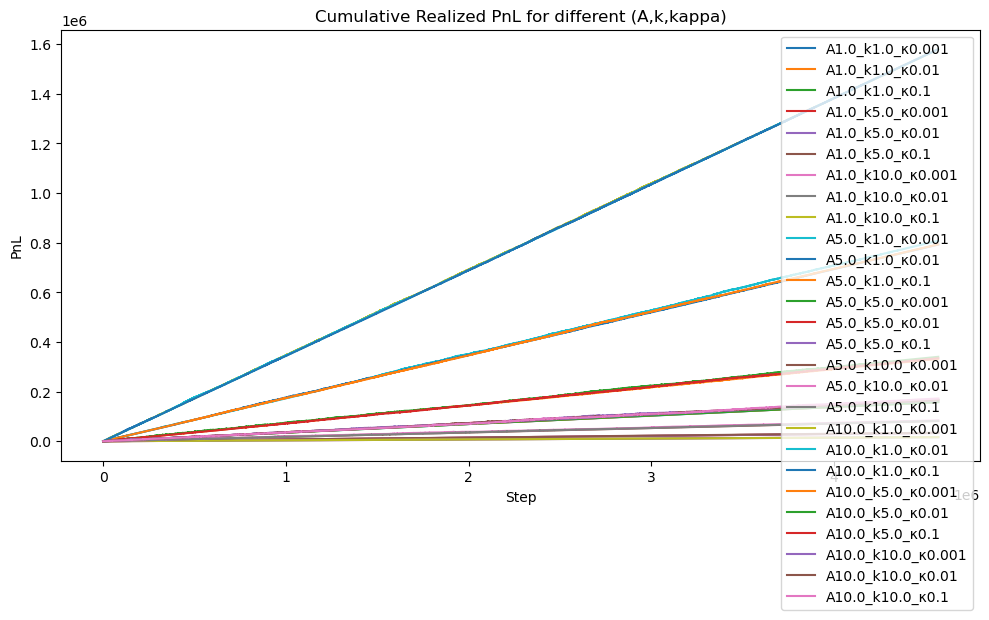

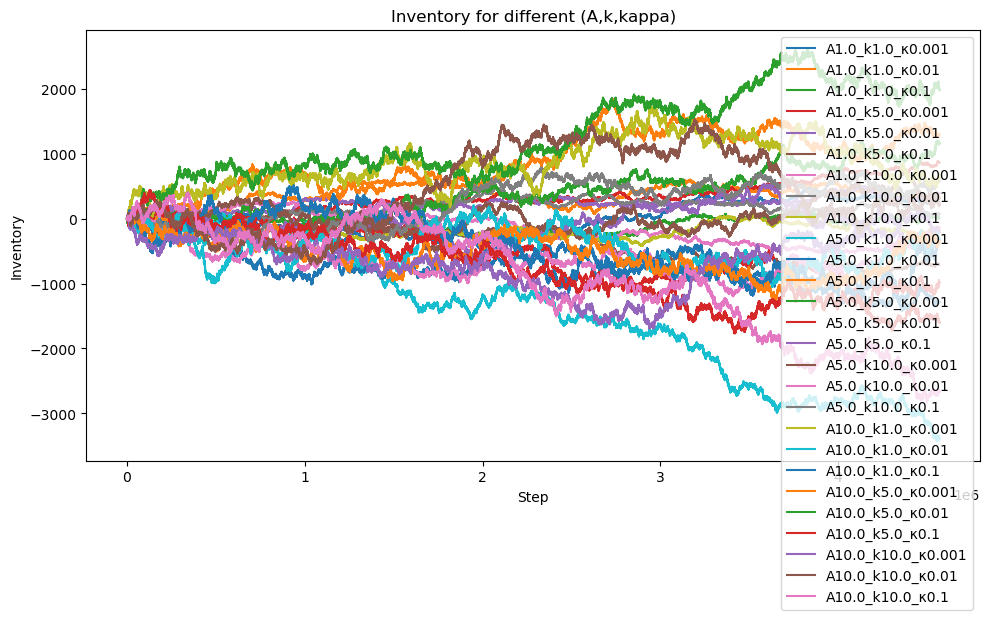

In [11]:
import os
import pandas as pd
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback

class TqdmCallback(BaseCallback):
    def __init__(self, total_timesteps: int, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
    def _on_training_start(self):   self.pbar = tqdm(total=self.total_timesteps, desc="Train")
    def _on_step(self):             self.pbar.update(1); return True
    def _on_training_end(self):     self.pbar.close()

data_dir = os.path.expanduser("/Users/diananigmatullina/Downloads/data_thesis")
df_list = []
for root, _, files in os.walk(data_dir):
    for f in files:
        if f.lower().endswith(".csv.gz"):
            tmp = pd.read_csv(os.path.join(root,f), parse_dates=["timestamp"])
            df_list.append(tmp[["timestamp","asks[0].price","bids[0].price"]])
df = pd.concat(df_list, ignore_index=True)
df.sort_values("timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)
mid = (df["asks[0].price"]+df["bids[0].price"])/2
real_sigma = mid.pct_change().dropna().std()
split = int(len(df)*0.8)
df_train, df_test = df.iloc[:split], df.iloc[split:]

class MarketMakingEnv(gym.Env):
    metadata={'render.modes':[]}
    def __init__(self, df, dt, kappa, A, k, beta, sigma, na=21, da=0.005, fee=0.001):
        super().__init__()
        self.dt, self.kappa, self.A, self.k = dt, kappa, A, k
        self.beta, self.sigma = beta, sigma
        self.na, self.da, self.fee = na, da, fee
        # спред
        self.Phi = 2.0/self.beta * np.log(1 + self.beta/self.k)
        self.half_spread = self.Phi/2.0
        self.mid_prices = ((df["asks[0].price"]+df["bids[0].price"])/2).values
        self.max_steps = len(self.mid_prices)-1
        self.action_space = spaces.Discrete(self.na)
        high = np.array([np.finfo(np.float32).max,
                         np.finfo(np.float32).max,
                         self.max_steps],dtype=np.float32)
        self.observation_space = spaces.Box(-high,high,dtype=np.float32)
        self.reset()
    def _get_obs(self):
        s=self.mid_prices[self.step_idx]
        tau=self.max_steps-self.step_idx
        return np.array([s,self.inventory,tau],dtype=np.float32)
    def reset(self):
        self.step_idx=0; self.inventory=0.; self.cash=0.; self.prev_wealth=0.
        self.mu_hat=0.; self.steps=0
        self.realized_pnl_series=[]; self.delta_w_series=[]
        return self._get_obs()
    def step(self,action):
        s=self.mid_prices[self.step_idx]
        mid_idx=(self.na-1)/2
        shift=(action-mid_idx)*self.da
        tau=self.max_steps-self.step_idx
        rho=s-self.beta*(self.sigma**2)*tau*self.inventory
        p_bid=rho+shift-self.half_spread
        p_ask=rho+shift+self.half_spread
        lam=self.A*np.exp(-self.k*self.half_spread)
        n_b=np.random.poisson(lam*self.dt)
        n_a=np.random.poisson(lam*self.dt)
        pnl_b=p_bid*n_b*(1-self.fee)
        pnl_a=p_ask*n_a*(1-self.fee)
        realized=pnl_a-pnl_b
        self.inventory+=n_b-n_a; self.cash+=realized; self.step_idx+=1
        done=self.step_idx>=self.max_steps
        s_next=self.mid_prices[self.step_idx]
        wealth=self.cash+self.inventory*s_next
        delta_w=wealth-self.prev_wealth; self.prev_wealth=wealth
        self.mu_hat=(self.steps*self.mu_hat+delta_w)/(self.steps+1); self.steps+=1
        reward=delta_w-0.5*self.kappa*(delta_w-self.mu_hat)**2
        self.realized_pnl_series.append(realized)
        self.delta_w_series.append(delta_w)
        return self._get_obs(), reward, done, {}

param_grid = {
    "A":     [1.0,   5.0,  10.0],
    "k":     [1.0,   5.0,  10.0],
    "kappa": [0.001, 0.01, 0.1]
}

runs = []
for A in param_grid["A"]:
    for k in param_grid["k"]:
        for kappa in param_grid["kappa"]:
            name = f"A{A}_k{k}_κ{kappa}"
            print("\n=== Run", name, "===")
            env = MarketMakingEnv(df_train, dt=0.05, kappa=kappa,
                                  A=A, k=k,
                                  beta=1.0, sigma=real_sigma)
            tot = env.max_steps * 5 
            model = DQN("MlpPolicy", env,
                        learning_rate=5e-4, batch_size=256, gamma=0.995,
                        train_freq=1, target_update_interval=5000,
                        exploration_fraction=0.1, exploration_final_eps=0.01,
                        buffer_size=200_000, verbose=0)
            model.learn(total_timesteps=tot, callback=TqdmCallback(tot))
            # тест
            env_test = MarketMakingEnv(df_test, dt=0.05, kappa=kappa,
                                       A=A, k=k,
                                       beta=1.0, sigma=real_sigma)
            obs = env_test.reset()
            cum_real, inv = [], []
            tr = 0.0
            done=False
            while not done:
                act,_ = model.predict(obs,deterministic=True)
                obs, _, done, _ = env_test.step(act)
                tr += env_test.realized_pnl_series[-1]
                cum_real.append(tr)
                inv.append(env_test.inventory)
            runs.append((name, cum_real, inv))

plt.figure(figsize=(10,6))
for name, cum_real, _ in runs:
    plt.plot(cum_real, label=name)
plt.title("Cumulative Realized PnL for different (A,k,kappa)")
plt.xlabel("Step"); plt.ylabel("PnL"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(10,6))
for name, _, inv in runs:
    plt.plot(inv, label=name)
plt.title("Inventory for different (A,k,kappa)")
plt.xlabel("Step"); plt.ylabel("Inventory"); plt.legend(); plt.tight_layout()

plt.show()